<a href="https://colab.research.google.com/github/Dagobert42/NMT-Attention/blob/main/Neural_Machine_Translation_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Machine Translation with Attention

The goal of this notebook is to implement the **RNNsearch-50** model, i.e., the encoder-decoder with attention system for any language pair different from English-German, German-English, English-French, and French-English. We choose **German-Italian** as an example language pair.

Furthermore we loosely follow **test-driven development** ("TDD") paradigms to replicate the original system based on the paper:

    Bahdanau, Cho & Bengio. Neural Machine Translation by Jointly Learning to Align and Translate. ICLR 2015.

# 1. Setup

Please choose which dependencies to install to your environment. On re-runs you can set these flags to false to save some time.

In [ ]:
from IPython.display import clear_output

torch = False #@param {type:"boolean"}
if torch:
    !pip install torch

torchtext = False #@param {type:"boolean"}
if torchtext:
    !pip install torchtext

spacy_nlp = True #@param {type:"boolean"}
if spacy_nlp:
    !pip install spacy

spacy_packages = True #@param {type:"boolean"}
if spacy_packages:
    !python -m spacy download en_core_web_sm
    !python -m spacy download de_core_news_sm
    !python -m spacy download it_core_news_sm

clear_output()

Next let us import all the modules we are going to be using.

In [ ]:
# access to translation datasets
import torchtext

# model implementation
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader

# tokenization
import spacy

# utilities
import math
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
from datetime import datetime
import gc

# storing data
import pickle
import uuid

# 2. Data

### 2.1 Vocabulary

The vocabulary converts words to indeces and vice versa. Unknown words are marked with the < U > token. The vocabulary can be filtered by word counts and provides methods for converting between sequences and sentences. It also takes an optional SpaCy NLP object which (when given) is used for tokenization.

In [ ]:
class Vocab:
    """
    A vocabulary holding dictionaries for converting words to indeces and back.
    """
    class Entry:
        def __init__(self, id):
            """ An entry to the vocabulary. With index and count. """
            self.id = id
            self.count = 1

        def __repr__(self):
            """ String prepresentation for printing. """
            return str((self.id, self.count))

    def __init__(self, text=None, spacy_nlp=None):
        """
        Creates a vocabulary over an input text in the form of
        dictionaries for indeces and word counts. Hand in a
        spacy_nlp object to make use of a SpaCy for tokenization.
        """
        self.spacy_nlp = spacy_nlp
        self.words = {'<S>':self.Entry(0),
                      '<E>':self.Entry(1),
                      '<U>':self.Entry(2),
                      '<P>':self.Entry(3)}
        self.ids = {0:'<S>',
                    1:'<E>',
                    2:'<U>',
                    3:'<P>'}
        self.next_id = 4

        if text:
            self.append(text)

    def append(self, txt):
        """ Adds a string token by token to the vocabulary. """
        # use SpaCy for tokenization if requested
        if self.spacy_nlp:
            for tok in self.spacy_nlp.tokenizer(txt):
                word = tok.text
                if word not in self.words.keys():
                    self.words[word] = self.Entry(self.next_id)
                    self.ids[self.next_id] = word
                    self.next_id += 1
                else:
                    self.words[word].count += 1
        else:
            for word in txt.split():
                if word not in self.words.keys():
                    self.words[word] = self.Entry(self.next_id)
                    self.ids[self.next_id] = word
                    self.next_id += 1
                else:
                    self.words[word].count += 1

    def filter(self, n_samples, descending=True):
        """
        Reduces this vocabs dictionary to n_samples and
        the 4 special tokens after sorting by word count.
        Indeces remain untouched
        """
        # exclude specials from sorting
        del self.words['<S>']
        del self.words['<E>']
        del self.words['<U>']
        del self.words['<P>']

        sorted_list = list(sorted(
                self.words.items(),
                key=lambda item: item[1].count,
                reverse=descending))
        
        # reinitialize dictionary
        self.words = {'<S>':self.Entry(0),
                      '<E>':self.Entry(1),
                      '<U>':self.Entry(2),
                      '<P>':self.Entry(3)}
        self.next_id = 4

        # add values from sorted list
        for word, entry in sorted_list[:n_samples-4]: # -4 specials
            entry.id = self.next_id # reindex, keep count
            self.words[word] = entry
            self.ids[self.next_id] = word
            self.next_id += 1

    def get_indeces(self, sentence):
        """ Produces a representation from the indeces in this vocabulary. """
        END = 1
        UNK = 2
        if self.spacy_nlp:
            seq = [self.words[tok.text].id if tok.text in self.words.keys() else UNK
                for tok in self.spacy_nlp.tokenizer(sentence)]
        else:
            seq = [self.words[word].id if word in self.words.keys() else UNK
                for word in sentence.split()]
        seq.append(END)
        return seq
    
    def get_sentence(self, indeces):
        """
        Converts a list of indeces into a readable sentence
        using words from this vocabulary.
        """
        return ' '.join([self.ids[id] for id in indeces])

We make sure the vocabulary works as intended by running tests with a tiny corpus. Note that during development these tests were written **first** and subsequently we implemented the related functionality in the class.

In [ ]:
TEST_CORPUS_EN = """The final project should implement a system 
        related to deep learning for NLP using the Py- Torch library 
        and test it. The project is documented in an ACL-style paper 
        that adheres to the standards of practice in computational 
        linguistics."""

test_vocab = Vocab(TEST_CORPUS_EN)

# Basic Functionality
assert(test_vocab.ids[0] == '<S>') # <S> should always be first
assert(test_vocab.ids[4] == 'The')
assert(test_vocab.words['The'].id == 4)
assert(test_vocab.words['The'].count == 2)

# Spacy Option
english_nlp = spacy.load('en_core_web_sm')
spacy_vocab = Vocab(TEST_CORPUS_EN, spacy_nlp=english_nlp)

assert(spacy_vocab.ids[0] == '<S>')
assert(spacy_vocab.ids[6] == 'project')
assert(spacy_vocab.words['project'].id == 6)
assert(spacy_vocab.words['project'].count == 2)

# Vocabulary Filter
top_30 = test_vocab
top_30.filter(n_samples=30)

assert(len(top_30.words) == 30)

# Sentence Vector Conversion
vec = spacy_vocab.get_indeces("This is a test")
sent = spacy_vocab.get_sentence(vec)

assert(vec == [2, 27, 9, 24, 1])
assert(sent == '<U> is a test <E>')

print('OK. No errors or asserts were triggered during testing :)')

OK. No errors or asserts were triggered during testing :)


### 2.2 Dataset

For data we look to the Web Inventory of Transcribed and Translated Talks which comes as a torchtext dataset.  You can see some examples during the building process. On re-runs you can set these flags to false to save some time.

In [ ]:
from torchtext.datasets import IWSLT2017
try:
    with open('train_pairs.pkl', 'rb') as f:
        train_pairs = pickle.load(f)

    with open('test_pairs.pkl', 'rb') as f:
        test_pairs = pickle.load(f)

    with open('val_pairs.pkl', 'rb') as f:
        val_pairs = pickle.load(f)
    print("loaded data from disk...")
except:
    print("unable to load data from disk...")
    print("downloading dataset from pytorch...")
    train_iter, test_iter, val_iter = IWSLT2017(
        split=('train', 'test', 'valid'),
        language_pair=('de', 'it'))
    
    train_pairs = [(src, trg) for src, trg in train_iter]
    with open('train_pairs.pkl', 'wb') as f:
        pickle.dump(train_pairs, f)

    test_pairs = [(src, trg) for src, trg in test_iter]
    with open('test_pairs.pkl', 'wb') as f:
        pickle.dump(test_pairs, f)

    val_pairs = [(src, trg) for src, trg in val_iter]
    with open('val_pairs.pkl', 'wb') as f:
        pickle.dump(val_pairs, f)

    print("data saved to disk...")
    
random.shuffle(train_pairs)
TRAIN_EXAMPLES = 100000 #@param {type:"integer"}
if TRAIN_EXAMPLES < len(train_pairs):
    train_pairs = train_pairs[:TRAIN_EXAMPLES]

print('sentence pairs in...')
print('...train:', len(train_pairs), end='\t')
print('...test:', len(test_pairs), end='\t')
print('...validation:', len(val_pairs))

loaded data from disk...
sentence pairs in...
...train: 100000	...test: 1567	...validation: 923


In [ ]:
rebuild_vocab = True #@param {type:"boolean"}
if not rebuild_vocab:
    try:
        with open('de_vocab.pkl', 'rb') as f:
            de_vocab = pickle.load(f)
        with open('it_vocab.pkl', 'rb') as f:
            it_vocab = pickle.load(f)
        print("loaded vocabularies from disk...")
    except:
        print("unable to load vocabularies from disk...")
        rebuild_vocab = True

if rebuild_vocab:
    de_nlp = spacy.load('de_core_news_sm')
    it_nlp = spacy.load('it_core_news_sm')
    de_vocab = Vocab(spacy_nlp=de_nlp)
    it_vocab = Vocab(spacy_nlp=it_nlp)

    PRINT_EVERY = 10000
    for n, (src, trg) in enumerate(train_pairs):
        if n % PRINT_EVERY == 0:
            clear_output()
            print("building vocabularies...\n")
            print(f'Example: {n}\n')
            print('source ->', src)
            print('target ->', trg)
        de_vocab.append(src)
        it_vocab.append(trg)

    VOCAB_SIZE = 10000 #@param {type:"integer"}
    de_vocab.filter(VOCAB_SIZE)
    it_vocab.filter(VOCAB_SIZE)

    with open('de_vocab.pkl', 'wb') as f:
        pickle.dump(de_vocab, f)

    with open('it_vocab.pkl', 'wb') as f:
        pickle.dump(it_vocab, f)

    print("vocabularies saved to disk...")

building vocabularies...

Example: 90000

source -> Er fragte sie. Sie sagten: "Wir wollen nichts von dir."

target -> Glielo chiese. Dissero: "Non vogliamo niente da te."

vocabularies saved to disk...


In [ ]:
def get_tensors(sentence_pairs, src_vocab, trg_vocab):
    data = []
    PRINT_EVERY = 10000
    for n, (src, trg) in enumerate(sentence_pairs):
        de_tensor = torch.tensor(src_vocab.get_indeces(src),
                                dtype=torch.long)
        it_tensor = torch.tensor(trg_vocab.get_indeces(trg),
                                dtype=torch.long)
        if n % PRINT_EVERY == 0:
            clear_output()
            print("converting to tensors...\n")
            print(f'example: {n}\n')
            print('source ->', de_tensor)
            print('target ->', it_tensor)
        data.append((de_tensor, it_tensor))
    return data
    
train_data = get_tensors(train_pairs, de_vocab, it_vocab)
test_data = get_tensors(test_pairs, de_vocab, it_vocab)
val_data = get_tensors(val_pairs, de_vocab, it_vocab)
clear_output()

# print a random example
x = random.randrange(0, len(train_pairs))
print(f'example: {x}\n')
print('source ->', train_pairs[x][0])
print('target ->', train_pairs[x][1])
print("as tensors:\n")
print('source ->', train_data[x][0], '\n')
print('target ->', train_data[x][1])

example: 94092

source -> Wegen des Regens ist bis vier Uhr nachmittags niemand in den Wahllokalen aufgetaucht.

target -> E per colpa della pioggia fino alle 4 del pomeriggio, nessuno è andato ai seggi.

as tensors:

source -> tensor([2920,   60,    2,   10,  145,  321, 1110,    2,  618,   13,   26,    2,
           2,    5,    6,    1]) 

target -> tensor([  21,   16, 2485,   34, 2441,  281,  147,  919,   26, 2744,    4,  419,
          10,  789,  128,    2,    6,    5,    1])


# 3. Model

The network consists of three main parts. These are the Encoder, Decoder and Alignment models which are ultimately combined to form the RNNsearch model.

## 3.1 Encoder

**Inputs:** sequence of one-hot vectors representing a sentence

**Outputs:** series of annotations, most recent GRU hidden states

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, dropout):
        super().__init__()

        self.embed = nn.Embedding(input_dim, embedding_dim)
        self.biRNN = nn.GRU(embedding_dim, hidden_dim, bidirectional = True)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        embeds = self.dropout(self.embed(src)) # [src_len, batch_size, embedding_dim]
        out, hidden = self.biRNN(embeds) # out = [src_len, batch_size, hiden_dim * 2]
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))) # [batch_size, hidden_dim]
        return out, hidden

## 3.2 Attention

**Inputs:** encodings, recent encoder hidden states

**Outputs:** attention energies over the input sequence

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_dim):
        super().__init__()

        self.attention = nn.Linear(hidden_dim * 3, attention_dim)
        self.v = nn.Linear(attention_dim, 1, bias = False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1) # [batch_size, src_len, hidden_dim]
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # [batch_size, src_len, hidden_dim * 2]
        
        energy = torch.tanh(self.attention(torch.cat((hidden, encoder_outputs), dim = 2))) # [batch_size, src_len, hidden_dim]
        soft_align = self.v(energy).squeeze(2) # [batch_size, src_len]
        return F.softmax(soft_align, dim=1)

## 3.3 Decoder

**Input:** encodings, recent encoder hidden states

**Outputs:** current prediction, hidden states

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention_dim, dropout):
        super().__init__()

        self.attention = Attention(hidden_dim, attention_dim)
        self.embed = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((hidden_dim * 2) + emb_dim, hidden_dim)
        self.fc_out = nn.Linear((hidden_dim * 2) + hidden_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0) # [1, batch_size]
        embeds = self.dropout(self.embed(input)) # [1, batch_size, embedding_dim]
        
        a = self.attention(hidden, encoder_outputs) # [batch_size, src_len]
        a = a.unsqueeze(1) # [batch_size, 1, src_len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # [batch_size, src_len, hidden_dim * 2]
        weighted = torch.bmm(a, encoder_outputs) # [batch_size, 1, hidden_dim * 2]
        weighted = weighted.permute(1, 0, 2) # [1, batch_size, hidden_dim * 2]
        
        rnn_input = torch.cat((embeds, weighted), dim = 2) # [1, batch_size, (hidden_dim * 2) + embedding_dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        embeds = embeds.squeeze(0) # [batch_size, embedding_dim]
        output = output.squeeze(0) # [batch_size, hidden_dim]
        weighted = weighted.squeeze(0) # [batch_size, hidden_dim * 2]
        prediction = self.fc_out(torch.cat((output, weighted, embeds), dim = 1))
        # resqueeze dimensions for translation pass
        return prediction, hidden.squeeze(0), a.squeeze(1)

## 3.4 Final Model

**Input:** encoded source sequence, empty target sequence

**Outputs:** encoded translation

In [ ]:
class Translator(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dim, attention_dim, dropout, device):
        super().__init__()
        self.trg_vocab_size = output_dim
        self.encoder = Encoder(input_dim, embedding_dim, hidden_dim, dropout)
        self.decoder = Decoder(output_dim, embedding_dim, hidden_dim, attention_dim, dropout)
        self.device = device

    def forward(self, src, trg):
        batch_size = src.shape[1] # src = [src_len, batch_size]
        trg_len = trg.shape[0] # trg = [trg_len, batch_size]
        
        outputs = torch.zeros(trg_len, batch_size, self.trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:] # first input to the decoder is the <S> token
        
        # passing input incrementally to the decoder
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            input = output.argmax(1)

        return outputs

# 4. Training

## 4.2 Batching

In the original training method 1600 sentence pairs are retrieved at every 20th update and sorted by length. Then 20 new mini-batches with 80 sentence pairs each are prepared from this data. This keeps the average length of batches comparably low since each batch is always the length of its longest sequence while all of its smaller sequences are being padded with the special token < P >.

In [ ]:
RESORT_DATA = True #@param {type:"boolean"}
if RESORT_DATA:

    def sort_data(data, max_len):
        #filter input sentences for max length
        data_pruned = []
        for pair in data:
            if pair[0].size()[0] < max_len:
                data_pruned.append(pair)
        # sort sentences by length of input sentence
        return list(sorted(
                    data_pruned,
                    key=lambda pair: pair[0].size()[0],
                    reverse=True))
        
    MAX_SENT_LENGTH = 20 #@param {type:"integer"}
    train_sorted = sort_data(train_data, MAX_SENT_LENGTH)
    test_sorted = sort_data(test_data, MAX_SENT_LENGTH)
    val_sorted = sort_data(val_data, MAX_SENT_LENGTH)
    print(f'Sentence pairs of input length < {MAX_SENT_LENGTH}:',
          len(train_sorted))

Sentence pairs of input length < 20: 57796


In [ ]:
def prepare_batches(data):
    """ Returns mini-batches from sorted data. """
    STA = 0.0
    PAD = 3.0
    de_batch = []
    it_batch = []
    for de_item, it_item in data:
        de_batch.append(torch.cat([torch.tensor([STA]), de_item], dim=0))
        it_batch.append(torch.cat([torch.tensor([STA]), it_item], dim=0))
    de_batch_padded = pad_sequence(de_batch, padding_value=PAD)
    it_batch_padded = pad_sequence(it_batch, padding_value=PAD)
    return de_batch_padded, it_batch_padded


BATCH_SIZE =   32#@param {type:"integer"}
train_batches = DataLoader(train_sorted, batch_size=BATCH_SIZE,
                           shuffle=True, collate_fn=prepare_batches)
test_batches = DataLoader(test_sorted, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=prepare_batches)
val_batches = DataLoader(val_sorted, batch_size=BATCH_SIZE,
                         shuffle=True, collate_fn=prepare_batches)

## 4.2 Hyperparameters

For our purposes we can adjust the hyperparameters to more reasonably expensive values in terms of training time.

In [ ]:
#@markdown Model Parameters
EMBEDDING_DIM =   32#@param {type:"integer"}
HIDDEN_DIM =   64#@param {type:"integer"}
ATTENION_DIM =   40#@param {type:"integer"}
DROPOUT = 0.5 #@param {type:"number"}
#@markdown Training Parameters
EPOCHS =   10#@param {type:"integer"}
RHO = 0.95 #@param {type:"number"}
EPSILON = 0.000001 #@param {type:"number"}
LEARNING_RATE = 0.005 #@param {type:"number"}
GRADIENT_CLIP = 1 #@param {type:"number"}

## 4.3 Model Declaration

We initialize the weights as proposed. Setting all biases to 0, the recurrent weight matrices to random orthogonal matrices and sampling all other weights from normal distribution.

In [ ]:
def init_weights(model):
    """ Initialises the model weights and biases. """
    for name, param in model.named_parameters():
      INIT_WEIGHTS_CLASSIC = False #@param {type:"boolean"}
      if INIT_WEIGHTS_CLASSIC:
        # recurrent layer weights
        if 'weight_ih_l' in name or 'weight_hh_l' in name:
            nn.init.orthogonal_(param.data)
        # recurrent layer biases
        elif 'bias_ih_l' in name or 'bias_hh_l' in name:
            nn.init.constant_(param.data, 0)
        # remaining params
        elif 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
      else:
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

Lets check the model that we can declare with these hyperparameters. 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

input_dim = len(de_vocab.words)
output_dim = len(it_vocab.words)

model = Translator(input_dim, output_dim, EMBEDDING_DIM, HIDDEN_DIM, ATTENION_DIM, DROPOUT, device).to(device)
model.apply(init_weights)
print("Initialized weights...")

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {n_parameters} trainable parameters:')
print(model)

USE_ADADELTA = False #@param {type:"boolean"}
if USE_ADADELTA:
    optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=RHO, eps=EPSILON)
else:
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_func = nn.CrossEntropyLoss(ignore_index=3)

Initialized weights...
The model has 2987040 trainable parameters:
Translator(
  (encoder): Encoder(
    (embed): Embedding(10000, 32)
    (biRNN): GRU(32, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attention): Linear(in_features=192, out_features=40, bias=True)
      (v): Linear(in_features=40, out_features=1, bias=False)
    )
    (embed): Embedding(10000, 32)
    (rnn): GRU(160, 64)
    (fc_out): Linear(in_features=224, out_features=10000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


## 4.4 Train Loop



In [ ]:
def train(model, train_batches, optimizer, loss_func, gradient_clip):
    """ Trains the model on the training data. """
    total_loss = 0
    n_batches = len(train_batches)
    model.train()

    for n, (x, y) in enumerate(train_batches):
        x = x.to(device=device, dtype=torch.long)
        y = y.to(device=device, dtype=torch.long)

        optimizer.zero_grad()

        output = model(x, y)
        output = output[1:].view(-1, output.shape[-1])
        y = y[1:].view(-1)

        loss = loss_func(output, y)

        loss.backward()
        clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()
        total_loss += loss.item()
        
        # indicate progress
        BAR_SIZE = 20
        n += 1
        avg_loss = total_loss / n
        i = math.ceil(n/n_batches * BAR_SIZE)
        print('\r', '#' * i, ' ' * (BAR_SIZE-i),
              '{:.2f}%'.format(n/n_batches * 100.0),
              '[batch loss: {:.4f}]'.format(loss.item()),
              '[epoch_loss: {:.4f}]'.format(avg_loss),
              end=' ')
        
    return avg_loss

In [ ]:
def evaluate(model, eval_batches, loss_func):
    """ Evaluates the model on the evaluation data. """
    model.eval()
    n_batches = len(eval_batches)
    total_loss = 0

    with torch.no_grad():
        for n, (x, y) in enumerate(eval_batches):
            x = x.to(device=device, dtype=torch.long)
            y = y.to(device=device, dtype=torch.long)
            
            output = model(x, y)

            output = output[1:].view(-1, output.shape[-1])
            y = y[1:].view(-1)

            loss = loss_func(output, y)
            total_loss += loss.item()

            # indicate progress
            BAR_SIZE = 20
            n += 1
            avg_loss = total_loss / n
            i = math.ceil(n/n_batches * BAR_SIZE)
            print('\r', '#' * i, ' ' * (BAR_SIZE-i),
                  '{:.2f}%'.format(n/n_batches * 100.0),
                  '[batch loss: {:.4f}]'.format(loss.item()),
                  '[eval_loss: {:.4f}]'.format(avg_loss),
                  end=' ')
            
    return avg_loss

In [ ]:
def time_since(start):
    s = time.time() - start
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
print("Begin training...")
start_time = time.time()
epoch_losses = []
eval_losses = []
lowest_loss = math.inf
for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1} @', datetime.now().strftime("%H:%M:%S"))
    epoch_loss = train(model, train_batches, optimizer, loss_func, GRADIENT_CLIP)
    print('')
    eval_loss = evaluate(model, val_batches, loss_func)
    print('\n[time elapsed: {}]'.format(time_since(start_time)))
    if eval_loss < lowest_loss:
        lowest_loss = eval_loss
        id = uuid.uuid1()
        torch.save(model.state_dict(), str(id) + '.pt')
    epoch_losses.append(epoch_loss)
    eval_losses.append(eval_loss)
print("Training finished...")

Begin training...
Epoch: 1 @ 15:53:01
 ####################  100.00% [batch loss: 4.7443] [epoch_loss: 5.3187] 
 ####################  100.00% [batch loss: 6.3235] [eval_loss: 5.0299] 
[time elapsed: 3m 47s]
Epoch: 2 @ 15:56:49
 ####################  100.00% [batch loss: 4.6455] [epoch_loss: 4.8369] 
 ####################  100.00% [batch loss: 2.9480] [eval_loss: 4.5876] 
[time elapsed: 7m 30s]
Epoch: 3 @ 16:00:32
 ####################  100.00% [batch loss: 4.9271] [epoch_loss: 4.6189] 
 ####################  100.00% [batch loss: 2.9562] [eval_loss: 4.5062] 
[time elapsed: 11m 10s]
Epoch: 4 @ 16:04:12
 ####################  100.00% [batch loss: 4.3596] [epoch_loss: 4.4827] 
 ####################  100.00% [batch loss: 4.4545] [eval_loss: 4.5530] 
[time elapsed: 14m 49s]
Epoch: 5 @ 16:07:51
 ####################  100.00% [batch loss: 4.4924] [epoch_loss: 4.3894] 
 ####################  100.00% [batch loss: 6.2446] [eval_loss: 4.6271] 
[time elapsed: 18m 29s]
Epoch: 6 @ 16:11:31
 ########

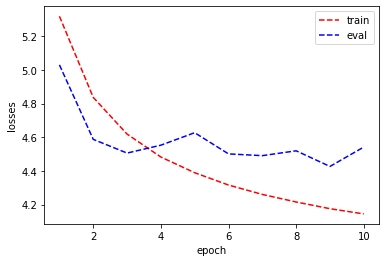

In [ ]:
def plot_losses(train_losses, eval_losses, name='losses', epochs=EPOCHS):
    x = range(1, epochs+1)
    plt.plot(x, train_losses, 'r--', label='train')
    plt.plot(x, eval_losses, 'b--', label='eval')
    plt.ylabel('losses')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(name + '.png', dpi=200)
    plt.show()

plot_losses(epoch_losses, eval_losses)

# 5. Evaluation

A trained model can be loaded by its UUID.

In [ ]:
LOAD_STATE = False #@param {type:"boolean"}
if LOAD_STATE:
    UUID = 'Your UUID' #@param {type:"string"}
    model.load_state_dict(torch.load(UUID + '.pt'))

In [ ]:
print("Begin evaluation...")
start_time = time.time()
test_loss = evaluate(model, test_batches, loss_func)

Begin evaluation...
 ####################  100.00% [batch loss: 2.9089] [eval_loss: 4.5556] 

## 5.1 Example Translations

In [ ]:
def translate(sentence, model, src_vocab, trg_vocab, device, max_len = MAX_SENT_LENGTH):
    """ Uses a model to translate a given sentence. """
    model.eval()

    src_indeces = src_vocab.get_indeces(sentence)
    src_tensor = torch.tensor(src_indeces).unsqueeze(1)
    src_tensor = src_tensor.to(device=device, dtype=torch.long)
    src_len = torch.LongTensor([len(src_tensor)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
        
    attentions = torch.zeros(max_len, 1, len(src_indeces)).to(device)
    trg_indeces = [src_vocab.words['<S>'].id]
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indeces[-1]]).to(device=device, dtype=torch.long)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)
        attentions[i] = attention
        pred_word_id = output.argmax(1).item()
        trg_indeces.append(pred_word_id)
        if pred_word_id == trg_vocab.words['<E>'].id:
            break
    
    trg_sequence = [trg_vocab.ids[id] for id in trg_indeces]
    return trg_sequence[1:], attentions[:len(trg_sequence)-1]

Lets look at some examples:

In [ ]:
def find_src_of_len(length, pairs):
    """ Returns the first sentence of the requested length. """
    for p in pairs:
        if len(p[0].split(' ')) == length:
            return p
    print('not found')

In [ ]:
pairs = train_pairs
random.shuffle(pairs)
example_lengths = [7, 12, 20]

for l in example_lengths:
    pair = find_src_of_len(l, pairs)
    sentence = pair[0]
    print('\nsource ->', sentence)
    print('target ->', pair[1])

    translation, attention = translate(sentence, model, de_vocab, it_vocab, device, MAX_SENT_LENGTH)
    print('translation ->', ' '.join(translation[:-1]))


source -> Albernheit in einem bisher völlig unbekannten Ausmaß.

target -> A un livello di stupidità impensabile.

translation -> <U> <U> un <U> un un un . . . . . 


source -> Neben vielen anderen eindrucksvollen Experimenten von Hannah ist dieses hier mein liebstes.

target -> Fra i molti esperimenti straordinari di Hannah, questo è uno dei miei preferiti.

translation -> <U> molti altri <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> preferiti . . 


source -> Stellen Sie sich vor, dass wir das tun könnten und stellen Sie sich vor, wir könnten die Leute mit einbeziehen.

target -> Quindi, immaginate di poterlo fare e immaginate di metterci al lavoro le persone.

translation -> <U> immaginate che immaginate , , , , persone persone persone persone . .


## 5.2 Visualizing Attention

We can visualize the soft-alignments learned by the network by plotting the attention energies over the source and target sequences.

In [ ]:
def show_attention(sentence, translation, attention, name='alignment'):
    """ Plots the learned soft alignment between source and translation. """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    attention = attention.squeeze(1).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + sentence.split(' ') + ['<E>'], rotation=90)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.savefig(name + '.png', dpi=200)
    plt.show()

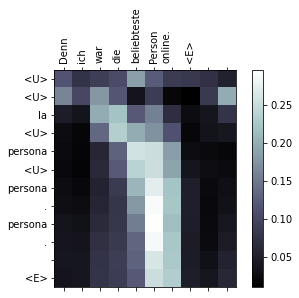

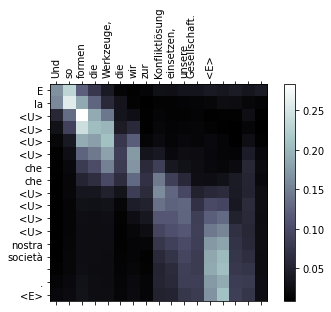

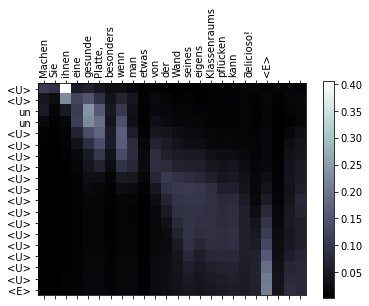

In [ ]:
pairs = train_pairs
random.shuffle(pairs)
example_lengths = [7, 12, 20]

for l in example_lengths:
    pair = find_src_of_len(l, pairs)
    sentence = pair[0]
    translation, attention = translate(sentence, model, de_vocab, it_vocab, device, MAX_SENT_LENGTH)
    show_attention(sentence, translation, attention, str(l))